# Exam Preparation: Vasicek

## Setup

In [29]:
import numpy as np
from scipy.stats import norm, ncx2, gamma
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Global settings for LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# local
import fixed_income_derivatives as fid

## Plotting ZCB Prices, Spot and Forward Rates

We use the information provided in the text to assign values to the parameter: 

In [30]:
# Vasicek model parameters
r0 = 0.02 # initial interest rate
a = 0.6 # rate of reversion
b = 0.03 # parameter to be used for long run mean
sigma = 0.02 # volatility parameter scaling the diffusion term

# compute array of time to maturities
N, T_max = 20, 10 # maturity up to 10Y
mesh = T_max/N # semi annual
tau = np.array([i*mesh for i in range(0, N+1)])
#print(tau)

Using that Vasicek possess an Affine term structure:

In [31]:
ZCB_prices = fid.zcb_price_vasicek(r0, a, b, sigma, tau)
spot_rates = fid.spot_rate_vasicek(r0, a, b, sigma, tau)
forward_rates = fid.forward_rate_vasicek(r0, a, b, sigma, tau)

Make a plot:

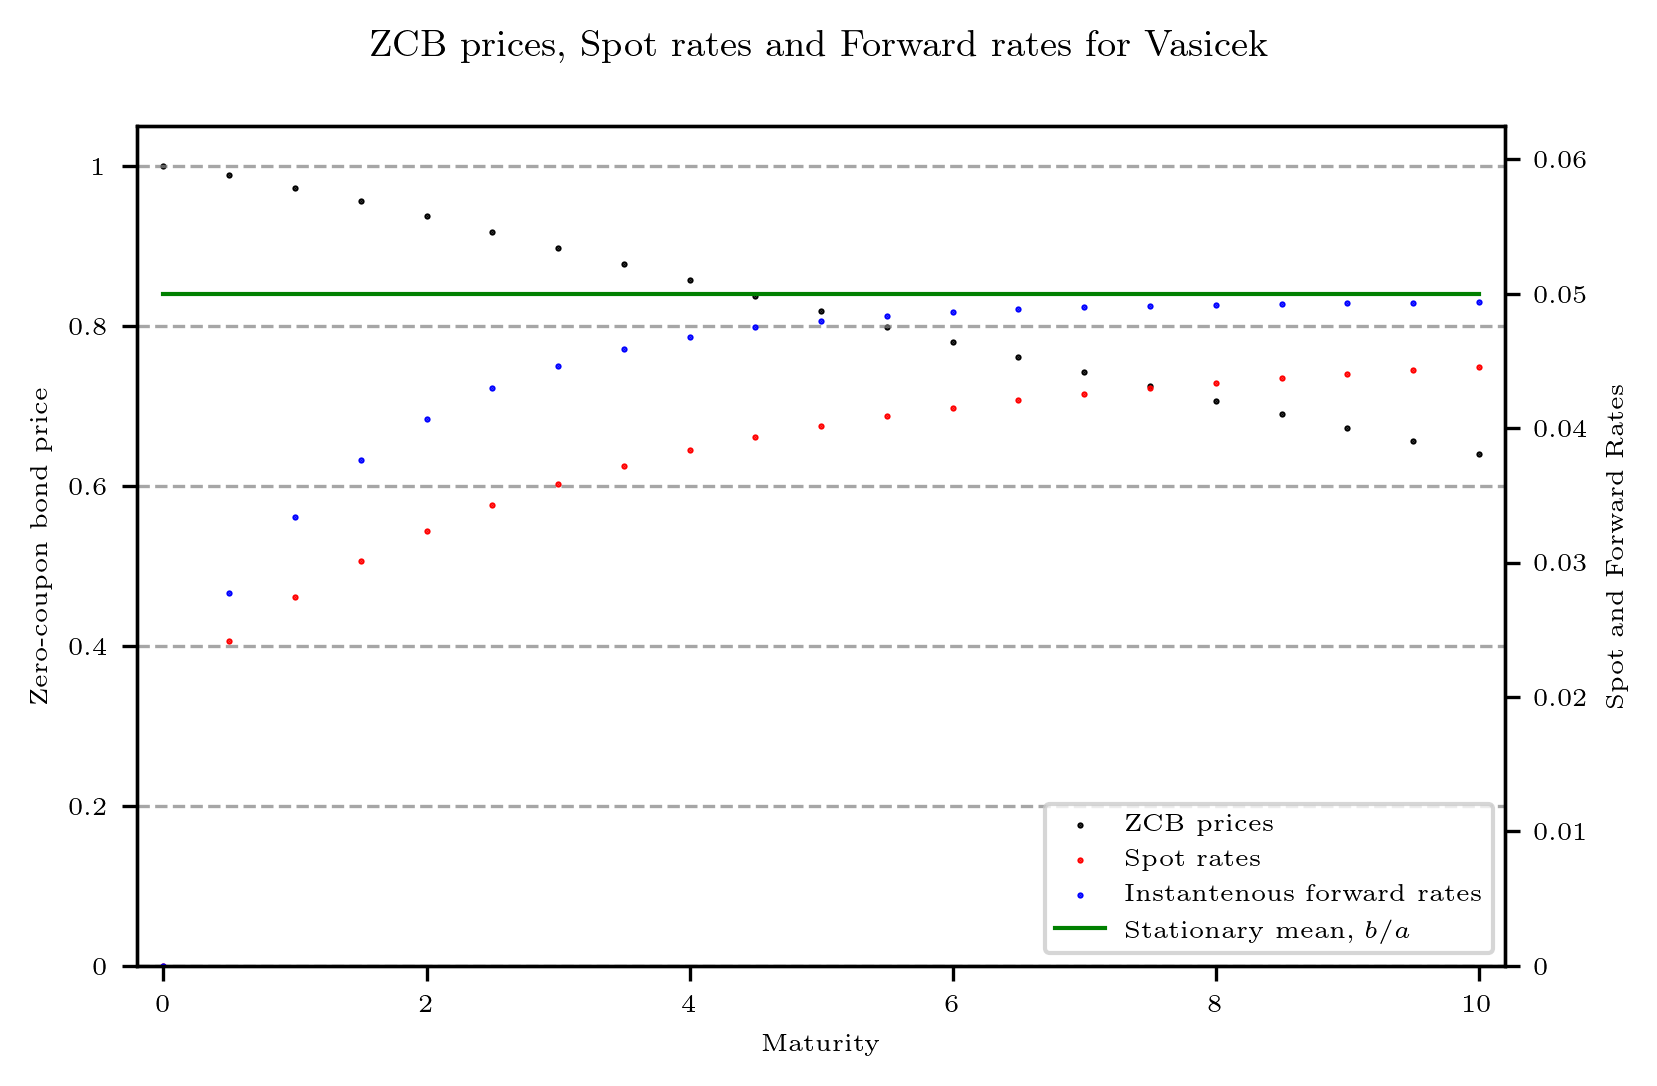

In [32]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"ZCB prices, Spot rates and Forward rates for Vasicek", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
#
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize = 6)
ax.set_ylim([0,1.05])
ax.set_ylabel(f"Zero-coupon bond price",fontsize = 6)
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

p1 = ax.scatter(tau, ZCB_prices, s = 1, color = 'black', marker = ".",label="ZCB prices")

## add second y-axis for the rates
ax1 = ax.twinx()
ax1.set_ylabel(f"Spot and Forward Rates",fontsize = 6)
ax1.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax1.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax1.set_ylim([0,0.0625])
p2 = ax1.scatter(tau, spot_rates, s = 1, color = 'red', marker = ".",label="Spot rates")
p3 = ax1.scatter(tau, forward_rates, s = 1, color = 'blue', marker = ".",label="Instantenous forward rates")
p4 = ax1.plot(tau, (b/a)*np.ones([N+1]), color = 'green', marker = "", linewidth = 1, linestyle = "solid",label = "Stationary mean, $b/a$")

plots = [p1,p2,p3,p4[0]]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

* ZCB prices decay
* Term structure of spot rates is upward sloping 
* Current rate of spot rate is below the stationary mean.
* Term structure of Forward rates is typically a bit further ahead.

## Fitting the Model 

**Fitting, not knowing $\sigma$**

Using the parameters given above we fit all the parameters in a Vasicek model to the spot rates. 
The purpose is to check if we are able to recover the parameters of the Vasicek model.

In [33]:
param_0 = 0.03, 0.4, 0.05, 0.03  # initial parameters (random guess)

# note, you might need to change tolerance if too many function evaluations
result = minimize(fid.fit_vasicek_obj, param_0, args=(spot_rates, tau), method='Nelder-Mead', options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 190
         Function evaluations: 334


In [34]:
r0_hat, a_hat, b_hat, sigma_hat, fct_value = result.x[0], result.x[1], result.x[2], result.x[3], result.x
print(f"The fitted values are: r0_hat: {r0_hat:.4f}, a_hat: {a_hat:.4f}, b_hat: {b_hat:.4f}, sigma_hat: {sigma_hat:.4f}")
print(f'SSE of the fit {result.fun:.6f}') # not surprisingly, it depends on xatol!

The fitted values are: r0_hat: 0.0197, a_hat: 0.6000, b_hat: 0.0307, sigma_hat: 0.0346
SSE of the fit 0.000000


Fitting the Vasicek model to spot rates with the objective of recovering all four parameters, we discover that $\sigma$ is difficult to recover implying that $\sigma$ is not well-specified in this model. Despite our inability to recover $\sigma$, we are nonetheless able to recover the remaining parameters $r_0, a$ and $b$ quite well.

**Comparing the Empirical and Fitted Spot Rates (and Prices)**

In [35]:
p_fit = fid.zcb_price_vasicek(r0_hat,a_hat,b_hat,sigma_hat,tau)
r_star, r_fit = np.zeros([N]), np.zeros([N])
for i in range(0,N):
    r_star[i] = - np.log(ZCB_prices[i+1])/(tau[i+1])
    r_fit[i] = - np.log(p_fit[i+1])/(tau[i+1])

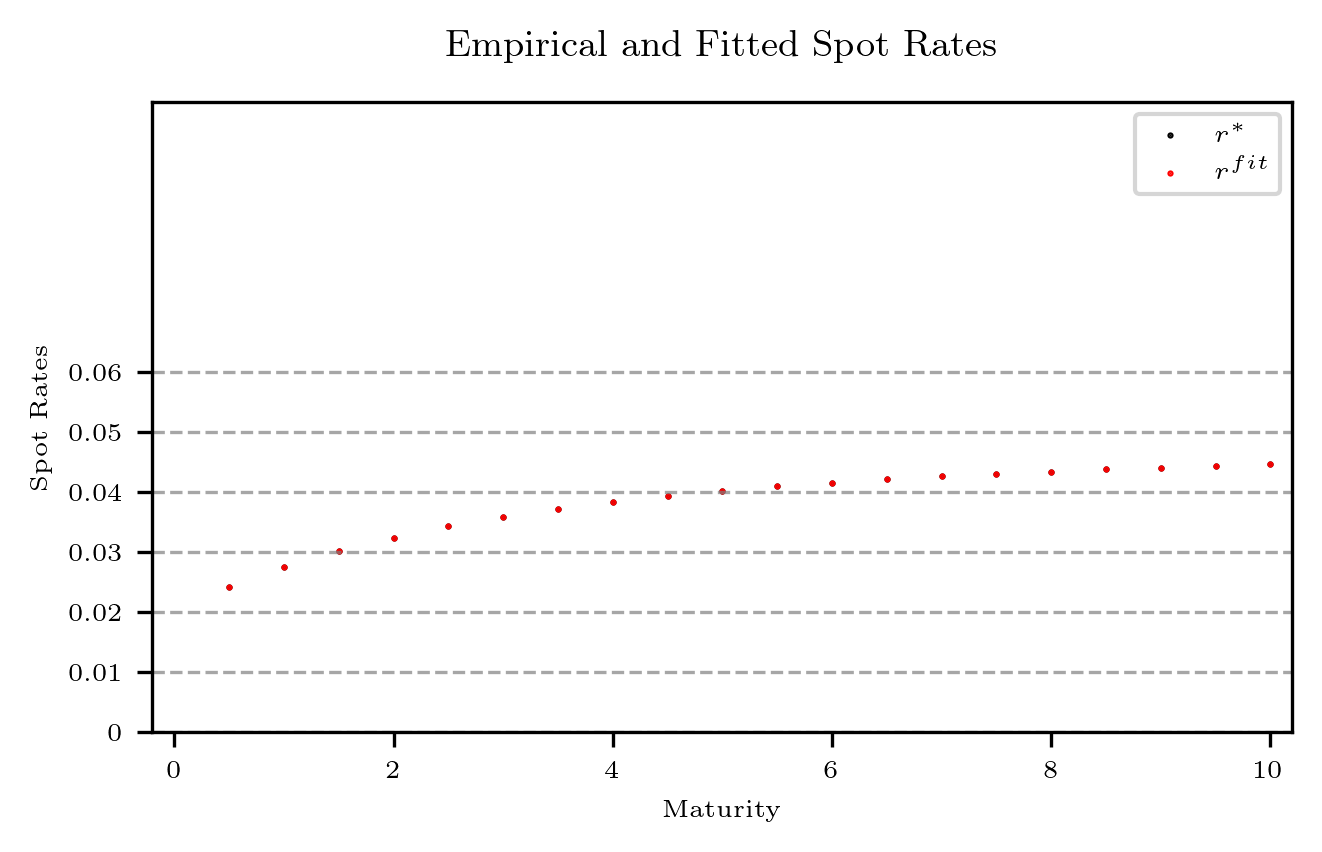

In [36]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"Empirical and Fitted Spot Rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.105])
ax.set_ylabel(f"Spot Rates",fontsize = 6)
p1 = ax.scatter(tau[1:], r_star, s = 1, color = 'black', marker = ".",label="$r^*$")
p2 = ax.scatter(tau[1:], r_fit, s = 1, color = 'red', marker = ".",label="$r^{fit}$")

plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 6)

plt.show()

They are smack on top.

**Fitting, knowing $\sigma$**

We do not recover sigma well. So suppose instead we know that sigma is some value. So we remove sigma from param and just put it as an input like "spot_rates" and "tau".

In [37]:
param_0 = 0.03, 0.4, 0.05 # no sigma!
result = minimize(fid.fit_vasicek_no_sigma_obj,param_0, method= "nelder-mead", args=(sigma, spot_rates,tau), options={'xatol': 1e-12, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 221
         Function evaluations: 403


In [38]:
r0_hat, a_hat, b_hat, fct_value = result.x[0], result.x[1], result.x[2], result.x
print(f"The fitted values are: r0_hat: {r0_hat:.4f}, a_hat: {a_hat:.4f}, b_hat: {b_hat:.4f}")
print(f'SSE of the fit {result.fun:.6f}') # not surprisingly, it depends on xatol!

The fitted values are: r0_hat: 0.0200, a_hat: 0.6000, b_hat: 0.0300
SSE of the fit 0.000000


If we fit the Vasicek model to spot rates assuming that $\sigma=0.02$ is known the algorithm will converge very fast and the remaining parameters be returned with high accuracy illustrating once again that $r_0, a$ and $b$ are very will identified in the model.

### Constrained Optimization (Notice, here we are fitting prices!)

In the previous, you have performed an unconstrained optimization in the sense that none of the parameters have been restricted to take values in a certain range. Next, we will investigate how to impose, bounds and constraints on the optimization and we will once again optimize over all four parameters $r, a, b, \sigma$. You will need to use that method 'trust-constr' also described in the documentation.

In [39]:
from scipy.optimize import Bounds, NonlinearConstraint

**A)** Imposing bounds: $0 \leq r \leq 0.1,0 
\leq a \leq 10,0 \leq b \leq 0.2$ and $0 \leq \sigma \leq 0.1$

In [40]:
def fit_vasicek_obj(param,p_star,T):
    """ SSE for fitted ZCB prices against 'market' data. """
    r0, a, b, sigma = param
    N = len(p_star)
    p_fit = fid.zcb_price_vasicek(r0,a,b,sigma,T)
    y = 0
    for i in range(0,N):
        y += 1e16*(p_fit[i] - p_star[i])**2
    return y

In [41]:
param_0 = (0.03, 1.8, 0.12, 0.03) # random
bounds = Bounds([0.,0,0,0],[0.1,10,0.2,0.1])
result = minimize(fit_vasicek_obj,param_0,method = 'trust-constr',bounds = bounds,args = (ZCB_prices,tau),options={'disp': True})
r0_hat, a_hat, b_hat, sigma_hat, SSE = result.x[0], result.x[1], result.x[2], result.x[3], result.fun
print(f"r0_hat: {r0_hat:.4f}, a_hat: {a_hat:.4f}, b_hat: {b_hat:.4f}, and sigma_hat: {sigma_hat:.4f}")
p_fit = fid.zcb_price_vasicek(r0_hat,a_hat,b_hat,sigma_hat,tau)
r_star, r_fit = np.zeros([N]), np.zeros([N])
for i in range(0,N):
    r_star[i] = - np.log(ZCB_prices[i+1])/(tau[i+1])
    r_fit[i] = - np.log(p_fit[i+1])/(tau[i+1])

`xtol` termination condition is satisfied.
Number of iterations: 231, function evaluations: 1340, CG iterations: 541, optimality: 3.43e+08, constraint violation: 0.00e+00, execution time: 0.49 s.
r0_hat: 0.0202, a_hat: 0.5998, b_hat: 0.0297, and sigma_hat: 0.0000


/Users/hanschristian/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [42]:
#r_fit

In [43]:
#r_star

**B)** Imposing bounds: $0 \leq r \leq 0.1,0 \leq a \leq 1.8, 0\leq b \leq 0.08$ and $0 \leq \sigma \leq 0.1$

In [44]:
param_0 = (0.03, 1.8, 0.12, 0.03) # random
bounds = Bounds([0.,0,0,0],[0.1,1.8,0.08,0.1])
result = minimize(fit_vasicek_obj,param_0,method = 'trust-constr',bounds = bounds,args = (ZCB_prices,tau),options={'disp': True})
r0_hat, a_hat, b_hat, sigma_hat, SSE = result.x[0], result.x[1], result.x[2], result.x[3], result.fun
print(f"r0_hat: {r0_hat:.4f}, a_hat: {a_hat:.4f}, b_hat: {b_hat:.4f}, and sigma_hat: {sigma_hat:.4f}")
p_fit = fid.zcb_price_vasicek(r0_hat,a_hat,b_hat,sigma_hat,tau)
r_star, r_fit = np.zeros([N]), np.zeros([N])
for i in range(0,N):
    r_star[i] = - np.log(ZCB_prices[i+1])/(tau[i+1])
    r_fit[i] = - np.log(p_fit[i+1])/(tau[i+1])

`xtol` termination condition is satisfied.
Number of iterations: 179, function evaluations: 1295, CG iterations: 361, optimality: 6.71e+07, constraint violation: 0.00e+00, execution time: 0.41 s.
r0_hat: 0.0000, a_hat: 1.3546, b_hat: 0.0647, and sigma_hat: 0.0000


In [45]:
#r_fit

In [46]:
#r_star

Now we get a much worse fit. 

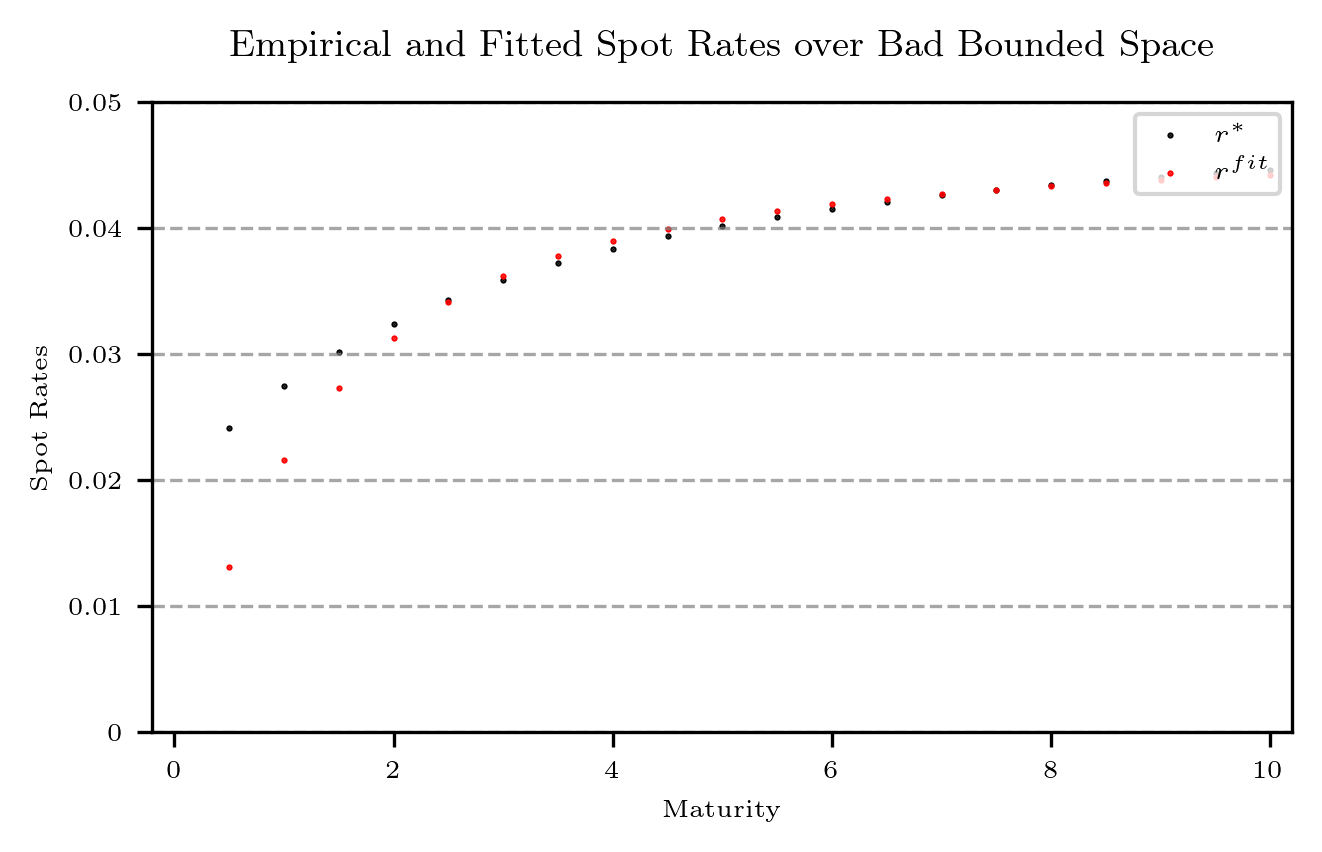

In [47]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"Empirical and Fitted Spot Rates over Bad Bounded Space", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])

xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.05])
ax.set_ylabel(f"Spot Rates",fontsize = 6)
p1 = ax.scatter(tau[1:], r_star, s = 1, color = 'black', marker = ".",label="$r^*$")
p2 = ax.scatter(tau[1:], r_fit, s = 1, color = 'red', marker = ".",label="$r^{fit}$")
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)


plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 6)

plt.show()

**C)** Imposing bounds + Adding non-linear constraints: 
$$0 \leq r \leq 0.1,0 
\leq a \leq 10,0 \leq b \leq 0.2$ and $0 \leq \sigma \leq 0.1$$
$$2 a b \geq \sigma^2$$

Auxiliary functions:

In [48]:
def cons_f(param):
    return [2*param[1]*param[2] - param[3]**2]

def cons_J(param):
    """ Jacobian."""
    return [[0,2*param[2],2*param[1],-2*param[3]]]

def cons_H(param,v):
    """ Hessian."""
    return v[0]*np.array([[0,0,0,0],[0,0,2,0],[0,2,0,0],[0,0,0,-2]])

In [49]:
param_0 = (0.03, 1.8, 0.12, 0.03) # random
bounds = Bounds([0.,0,0,0],[0.1,10,0.2,0.1])
nonlinear_constraint = NonlinearConstraint(cons_f, 0, np.inf, jac=cons_J, hess=cons_H)
result = minimize(fit_vasicek_obj,param_0,method = 'trust-constr',args = (ZCB_prices,tau),bounds = bounds,constraints=[nonlinear_constraint],options={'disp': True})
r0_hat, a_hat, b_hat, sigma_hat, SSE = result.x[0], result.x[1], result.x[2], result.x[3], result.fun
print(f"r0_hat: {r0_hat:.4f}, a_hat: {a_hat:.4f}, b_hat: {b_hat:.4f}, sigma_hat: {sigma_hat:.4f}")
print(f"r0: {r0:.2f}, a: {a:.2f}, b: {b:.2f}, sigma: {sigma:.2f}")

ZCB_fit = fid.zcb_price_vasicek(r0_hat,a_hat,b_hat,sigma_hat,tau)
r_star, r_fit = np.zeros([N]), np.zeros([N])
for i in range(0,N):
    r_star[i] = - np.log(ZCB_prices[i+1])/(tau[i+1])
    r_fit[i] = - np.log(ZCB_fit[i+1])/(tau[i+1])

`xtol` termination condition is satisfied.
Number of iterations: 248, function evaluations: 2165, CG iterations: 609, optimality: 7.84e+07, constraint violation: 0.00e+00, execution time: 0.54 s.
r0_hat: 0.0202, a_hat: 0.5996, b_hat: 0.0296, sigma_hat: 0.0000
r0: 0.02, a: 0.60, b: 0.03, sigma: 0.02


In [50]:
#r_star

In [51]:
#r_fit

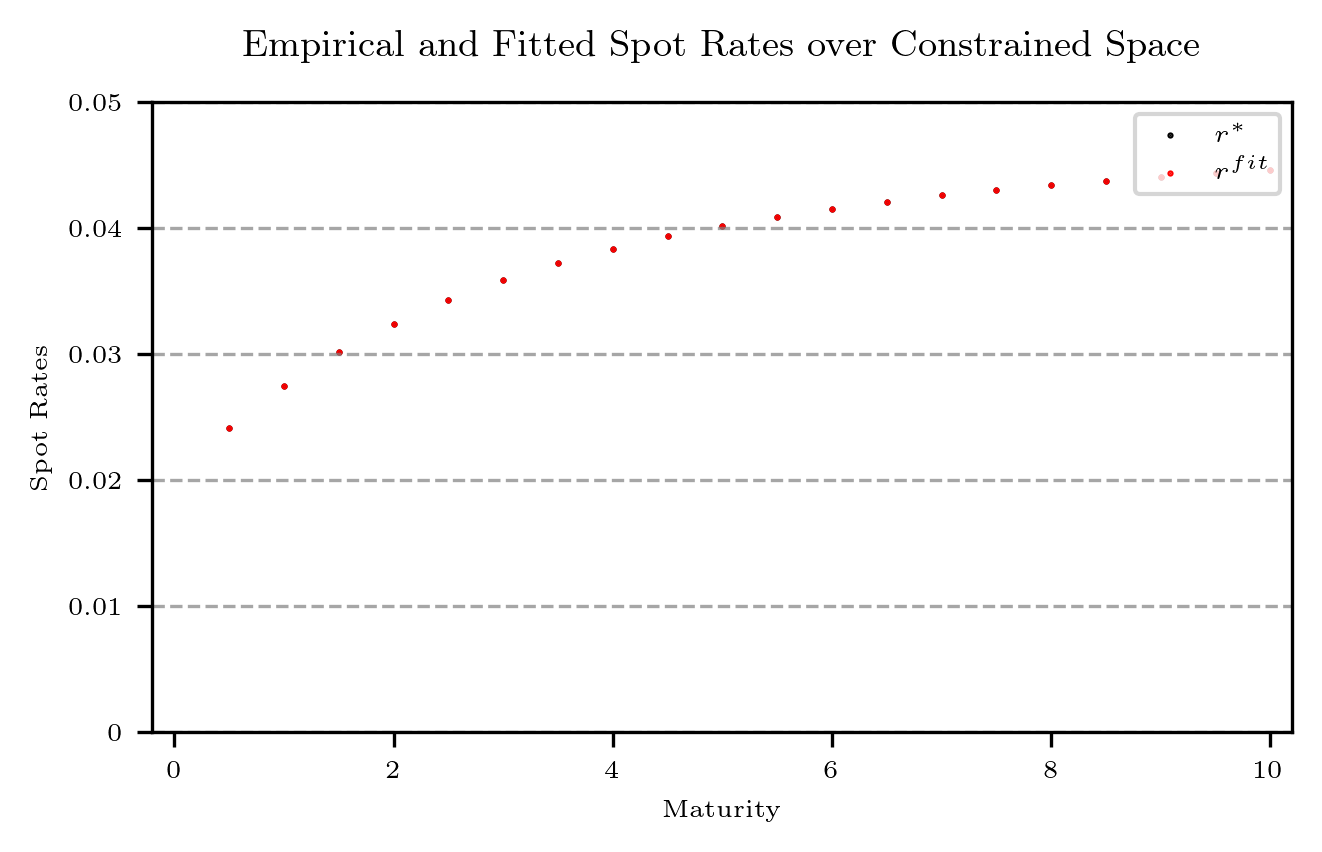

In [52]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"Empirical and Fitted Spot Rates over Constrained Space", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])

xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.05])
ax.set_ylabel(f"Spot Rates",fontsize = 6)
p1 = ax.scatter(tau[1:], r_star, s = 1, color = 'black', marker = ".",label="$r^*$")
p2 = ax.scatter(tau[1:], r_fit, s = 1, color = 'red', marker = ".",label="$r^{fit}$")
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 6)

plt.show()

## Simulating

We simulate the dynamics of the short rate in the Vasicek model
$$
\begin{aligned}
d r_t & =\left(b-a r_t\right) d t+\sigma d W_t, \quad t>0 \\
r(0) & =r_0
\end{aligned}
$$
on a grid of mesh $\delta$ that runs from initial time $t_0=0$ to some terminal time $T$. Denote by $\mathrm{N}$, the number of steps in your simulation. The time points in your simulation will be numbered $n=0,1,2, \ldots, N-1, N$ and the time points will be $\left[t_0, t_1, \ldots, t_{N-1}, t_N\right]=[0, \delta, 2 \delta, \ldots, T-\delta, T]$ and equidistant time steps $\delta=\frac{T}{N}$. The scheme you will need to implement is a simple Euler first-order scheme of the form
$$
r_n=r_{n-1}+\left(b-a r_{n-1}\right) \delta+\sigma \sqrt{\delta} Z_n, \quad n=1,2, \ldots, N
$$
where $Z_n \sim N(0,1), n=1, \ldots, N$ and all the standard normal random variables are independent.

### Simulating One Trajectory

In [53]:
r0, a, b, sigma = 0.02, 0.6, 0.03, 0.02
size_ci = 0.95 # confidence interval
T, N = 10, 50_000 # maturity, time steps 
param = (a,b,sigma)
delta = T/N # step size
r = fid.short_rate_simul(r0,param,N,T,method = "vasicek")
tau = np.array([i*delta for i in range(0,N+1)])

# confidence bounds
lb,ub = fid.ci_vasicek(r0,a,b,sigma,tau,size_ci,method = "two_sided") # lower & upper bound
lb_sd = (b/a-1.96*sigma/np.sqrt(2*a))*np.ones([N+1])
ub_sd = (b/a+1.96*sigma/np.sqrt(2*a))*np.ones([N+1])

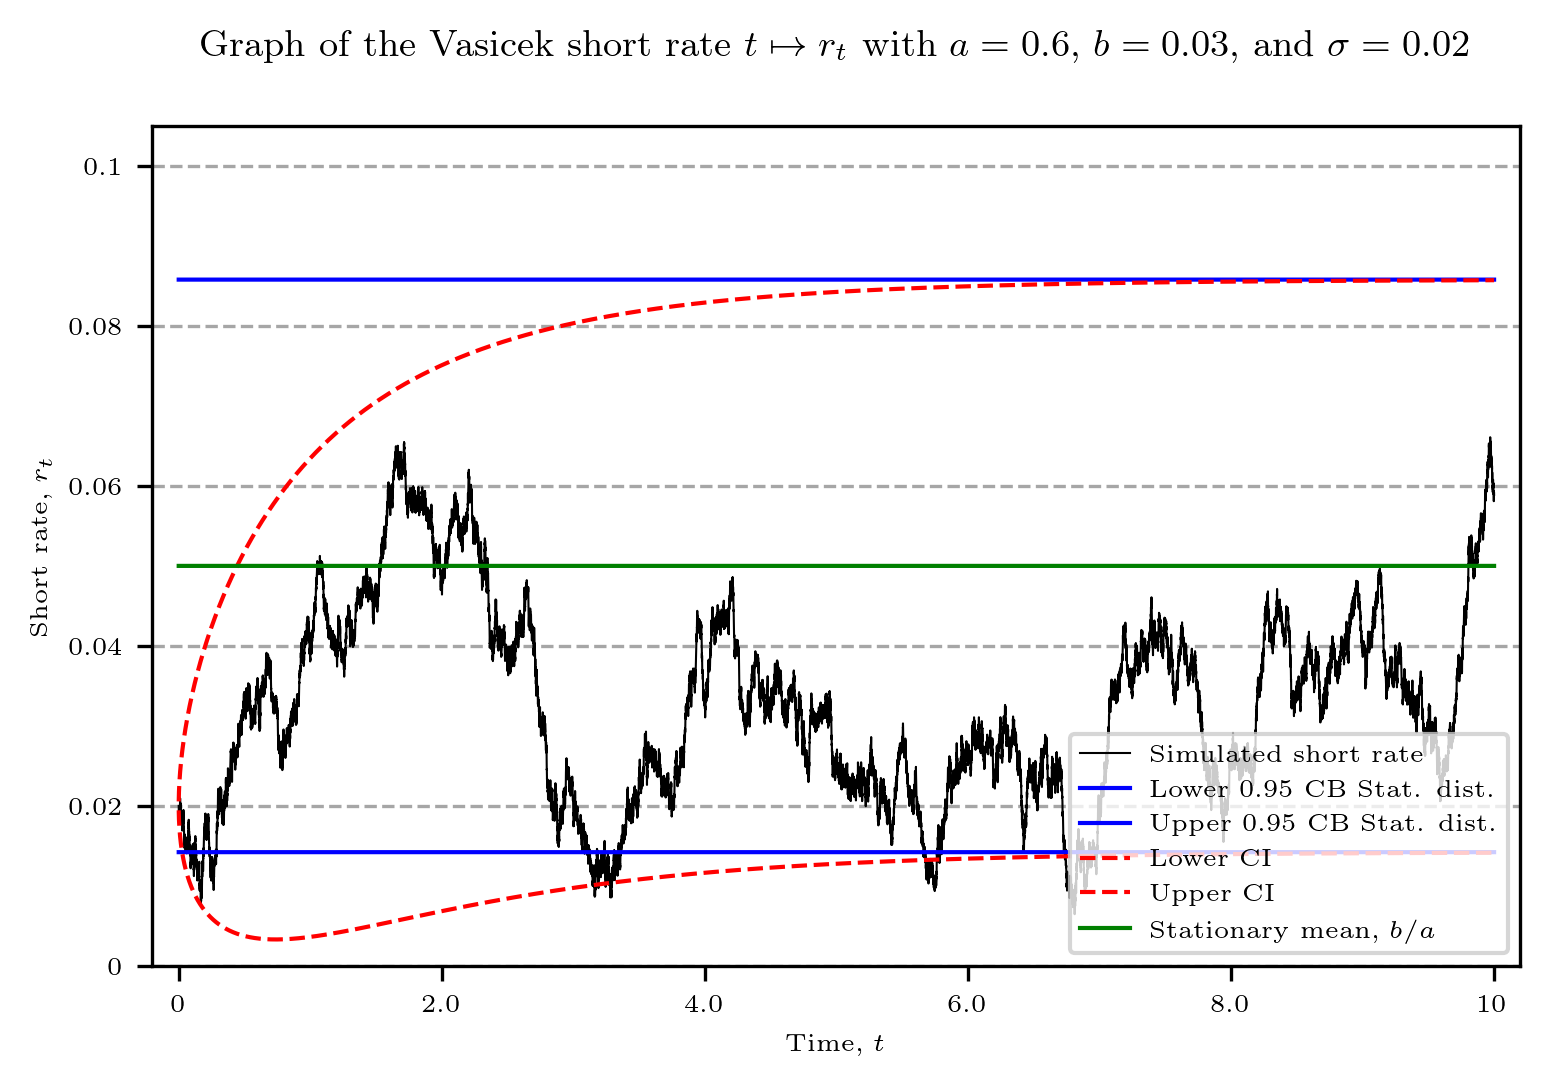

In [54]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"Graph of the Vasicek short rate $t \mapsto r_t$ with $a={a}$, $b={b}$, and $\sigma={sigma}$", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)


xticks = [0,(1/5)*T,(2/5)*T,(3/5)*T,(4/5)*T,T]
xticklabels = [round(i,3) for i in xticks]
yticks = [0,0.02,0.04,0.06,0.08,0.1]

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Time, $t$",fontsize = 6)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize = 6)
ax.set_ylim([yticks[0],yticks[-1]*1.05])
ax.set_ylabel(f"Short rate, $r_t$",fontsize = 6)

# simulated short rate
ax.plot(tau, r, color = 'black', marker = "", linewidth = 0.5, label = "Simulated short rate")

# stationary CI
ax.plot(tau,lb_sd,color = 'blue',marker = "", linewidth = 1, label = "Lower 0.95 CB Stat. dist.")
ax.plot(tau,ub_sd,color = 'blue',marker = "", linewidth = 1, label = "Upper 0.95 CB Stat. dist.")

# simulated CI
ax.plot(tau, lb, color = 'red', marker = "", linewidth = 1, linestyle = "dashed", label = "Lower CI")
ax.plot(tau, ub, color = 'red', marker = "", linewidth = 1, linestyle = "dashed", label = "Upper CI")

# stationary mean
ax.plot(tau, (b/a)*np.ones([N+1]), color = 'green', marker = "", linewidth = 1, linestyle = "solid",label = "Stationary mean, $b/a$")

ax.legend(loc = "lower right",fontsize = 6)
plt.show()

One simulated trajectory of the short rate can be seen in the plot.

* The Vasicek model may become negative due to its Gaussian distribution. Although real interest rates may sometimes fall below zero, this can be regarded as a potential drawback of the Vasicek model. The next code provides a numerical solution of the stochastic different. 
* Confidencen bounds should narrow as it comes closer to the bounds of the statioanry distribution.

The value $r_5$ in the simulation is of course the short three years after the initial point, and since the confidence interval of $r_5$ is different from that of the stationary distribution, we can conclude that 3 years is not enough time for the short rate to settle to its stationary distribution. Convergence to the stationary distribution will be faster if either $a$ is large or $\sigma$ is small.

# nexdt

c) we know the first half-year, so we don't have to take into account that some time of the initial libor rate has already past.
$$
R_{\text {swap }}(t=0)=\frac{P(0,0)-p(0, N)}{S_{\text {swap }}}
$$

Where the denominator is the accrual factor which comes from the fixed leg: $\sum_{i=1}^N \alpha_i p\left(t, T_i\right)$ where $\alpha$ is tenor. The floating leg was simply since we could compute it as a telescoping sum.

In [55]:
# 10 Y swap price
idx_n, idx_N = 0, 20 # first and last fixing where 20/2 = 10Y
S_swap = 0 
for idx in range(idx_n+1,idx_N+1): # already added 1 to M, hence no need for M+1 here, so M is included!
    S_swap += alpha*p[idx]

R_swap = (p[idx_n]-p[idx_N])/S_swap
    

NameError: name 'alpha' is not defined

In [ ]:
print(f'R_swap is {R_swap}')

New we have to do it for all maturities and not just for 10Y

In [ ]:
def R_swap_fct(idx_n, idx_N,alpha,p):
    """ Return swap rate for all maturieis
    
    Param:
    
    Return:
    array
    """
    S_swap = 0 
    for idx in range(idx_n+1,idx_N+1): # already added 1 to M, hence no need for M+1 here, so M is included!
        S_swap += alpha*p[idx]

    R_swap = (p[idx_n]-p[idx_N])/S_swap
    
    return R_swap, S_swap

In [ ]:
R_swap_plot, S_swap_plot = np.zeros([M]), np.zeros([M])

for i in range(1,M):
    R_swap_plot[i], S_swap_plot  = R_swap_fct(0, i,alpha,p)
print(R_swap_plot)

In [ ]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"ZCB prices, spot rates and forward rates for Vasicek", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
#
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize = 6)
ax.set_ylim([0,1.05])
ax.set_ylabel(f"ZCB prices",fontsize = 6)
p1 = ax.scatter(T, p, s = 1, color = 'black', marker = ".",label="p")
#
ax1 = ax.twinx()
ax1.set_yticks([0,0.02,0.04,0.06,0.08,0.1])
ax1.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1],fontsize = 6)
ax1.set_ylim([0,0.1025])
p2 = ax1.plot(T, (b/a)*np.ones([N+1]), color = 'black', marker = "", linewidth = 1, linestyle = "solid",label = "b/a")
p3 = ax1.scatter(T, R, s = 1, color = 'red', marker = ".",label="R")
p4 = ax1.scatter(T, f, s = 1, color = 'blue', marker = ".",label="f")
p4 = ax1.scatter(T, b/a*np.ones([N+1]), s = 0.25, color = "green", marker = ".",label="b/a")

plots = [p1,p2[0],p3]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 6)

plt.show()

We see that the par swap rates and ZCB spot rates are almost the same. The net cahs flow (fix - float) for payer swap is quite small, so the net payment until the end is relative small. Likewise, for ZCB the payment is at the very end. Remember the accrual factor of a swap is change in value of swap if par-swap rate changes by 1 bp, essentially sensitive of bond price to changes in par-swap rate. Likewise, for a regular duration is the change in value of a bond for a unit change in YTM. So you can say that accrual factor plays same role as duration for ZCB. Notice, duration of ZCB is equal to maturity.

Alternatively, we can interpret duration as average time until you get your cash flow back, hence larger maturity the longer it takes to get investment back.Duration is a measure of when that happens. Hence why equal to maturity to ZCB. Hence duration of a bond is proportional to maturity. In our case, for maturity 10 Y bond the S_Swap (accrual factor which is approx duration) is 8.11 years!

# Interest rate cap

An interest rate cap is an instrument that caps the coupon payment interest on floating rate obligations. So cap puts a cap on all coupons, whereas a caplets puts on one coupon payment.

In [ ]:
# using slide xi 5
strike = 0.05
idx_cap_bein, idx_cap_end = 2, 20 # no caplet for index since we already know
price_caplet = np.zeros([M])
for i in range(2,M):
    price_caplet[i] = (1+ alpha*strike)*fid.euro_option_price_vasicek1/1(1+alpha*strike),T[i-1],T[i], p[i-1],p[i],a,sigma,type = 'call')
    
price_cap = sum(price_caplet[idx_cap_begin:idx_cap_end])
#distributed price of caps into payments as a spread on top of floating rate in order to be insured against floating rate of 5 % (strike)
premium = alpha*(price_cap/s_swap) # where alpha is year fraction (6M)
print(f'Cap price: {price_cap}, cap premium {10000*premium}') # "1000", to turn premium into basis points
                

So pays 20 basis points on top of semi annual coupon payments to be insured.

iii)
Computing the dollar value of sigma changing, how sensitive is valuation of cap to changes in cap, where sigma is diffusion coefficient in Vasicek model.

In [ ]:
def price_cap_fct(sigma, strike,S_swap,idx_cap_begin,idx_cap_end,M,alpha,T,a):
    price_caplet = np.zeros([M])
    for i in range(2,M):
        price_caplet[i] = (1+ alpha*strike)*fid.euro_option_price_vasicek(1/1(1+alpha*strike),T[i-1],T[i], p[i-1],p[i],a,sigma,'call')

    price_cap = sum(price_caplet[idx_cap_begin:idx_cap_end])
    premium = alpha*(price_cap/s_swap) # where alpha is year fraction (6M)

In [ ]:
price_cap_bump, premium_bump = price_cap_fct(sigma-0.001,strike_S_swap, idx_cap_begin,idx_cap_end,M,alpha,T,a)


If sigma goes down by 0.0001 then the price of the caplet falls. The likelihood of libor going crazy (high volaitlity) is reduced when you choose lower sigma. So in essence reducing uncertainty.

## Simulate, e

The Vasicek is Gaussian, thus it can go negative. The plot also reveals the speed with which we tend to the staionrty distribution, which is around maturity 10, with same Confidence Intervals( CI).

## PAywer Swaption

At time zero we observe forward 2Y8Y par swap rate, but in 2 years it becomes spot par swap rate. If that 8y in two yeras exceeds strike, then you make bank which is giveni in first Eq. in text. So we simulate short rate for two yeras, then use that to compute par swap rate that now is a 8y spot par swap rate and compute corresponding accrual factor to get payoff in two years for that given trajectory of short rate and then multiply by payoff to get discounted payoff. doing this many times and averaging gies fair value,

We get roughly 1.5%.